## Imports and settings

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import sys
import json
from pprint import pprint
import collections
import pickle

import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import ipywidgets as widgets
from matplotlib import gridspec
from scipy.stats import gaussian_kde
from tqdm import tqdm

project_root = '..'
sys.path.append(project_root)

from sleep.data.loader import load_dataset
from sleep.data import utils
from sleep.detection.feeder_dataset import FeederDataset
from sleep.detection import metrics
from sleep.common import constants

SEED_LIST = [123, 234, 345, 456]
RESULTS_PATH = os.path.join(project_root, 'results')
COMPARISON_PATH = os.path.join(project_root, 'resources', 'comparison_data')
DPI = 200
CUSTOM_COLOR = {'red': '#c62828', 'grey': '#455a64', 'blue': '#0277bd', 'green': '#43a047'} 

%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## Load database and predicted probabilities

In [2]:
ckpt_folder = os.path.join('20190510_bsf_aug_rescale_uniform_wn_train_mass_ss', 'bsf')
optimal_xval_thr = 
task_mode = constants.WN_RECORD
dataset_name = constants.MASS_SS_NAME
seed_id_list = [0, 1, 2, 3]

n_seeds = len(seed_id_list)
set_list = [constants.TRAIN_SUBSET, constants.VAL_SUBSET, constants.TEST_SUBSET]
which_expert = 1
verbose = False

# Load data
dataset = load_dataset(dataset_name)
all_train_ids = dataset.train_ids
test_ids = dataset.test_ids
predictions_dict = {}
for k in seed_id_list:
    # Restore predictions
    ckpt_path = os.path.abspath(os.path.join(
        RESULTS_PATH,
        'predictions_%s' % dataset_name,
        ckpt_folder,
        'seed%d' % k
    ))
    this_dict = {}
    for set_name in set_list:
        filename = os.path.join(
                ckpt_path,
                'prediction_%s_%s.pkl' % (task_mode, set_name))
        with open(filename, 'rb') as handle:
            this_pred = pickle.load(handle)
        this_dict[set_name] = this_pred
    predictions_dict[k] = this_dict
    print('Loaded seed %d/%d from %s' % (k + 1, n_seeds, ckpt_path))

Train size: 11. Test size: 4
Train subjects: 
 [1, 3, 5, 7, 9, 10, 11, 14, 17, 18, 19]
Test subjects: 
 [2, 6, 12, 13]
Dataset mass_ss with 15 patients.
Loading from checkpoint... Loaded
Loaded seed 1/4 from /home/ntapia/Projects/GitNico/sleep-rnn/results/predictions_mass_ss/20190509_bsf_with_aug_n2_train_mass_ss/bsf/seed0
Loaded seed 2/4 from /home/ntapia/Projects/GitNico/sleep-rnn/results/predictions_mass_ss/20190509_bsf_with_aug_n2_train_mass_ss/bsf/seed1
Loaded seed 3/4 from /home/ntapia/Projects/GitNico/sleep-rnn/results/predictions_mass_ss/20190509_bsf_with_aug_n2_train_mass_ss/bsf/seed2
Loaded seed 4/4 from /home/ntapia/Projects/GitNico/sleep-rnn/results/predictions_mass_ss/20190509_bsf_with_aug_n2_train_mass_ss/bsf/seed3


## Performance: F1 vs IoU curve

In [3]:
# ---------------- Compute performance
f1_vs_iou_dict = {}
iou_list = np.arange(21) * 0.05
for k in seed_id_list:
    # Prepare expert labels
    data_test = FeederDataset(
        dataset, test_ids, task_mode, which_expert=which_expert)
    this_events = data_test.get_stamps()
    # Prepare model predictions
    prediction_test = predictions_dict[k][constants.TEST_SUBSET]
    prediction_test.set_probability_threshold(optimal_xval_thr)
    this_detections = prediction_test.get_stamps()
    this_f1_vs_iou = metrics.metric_vs_iou_with_list(
        this_events, this_detections, iou_list)
    f1_vs_iou_dict[k] = this_f1_vs_iou
    
# Mean performance
mean_f1_vs_iou = np.stack([f1_vs_iou_dict[k] for k in seed_id_list], axis=1).mean(axis=1)
std_f1_vs_iou = np.stack([f1_vs_iou_dict[k] for k in seed_id_list], axis=1).std(axis=1)
pprint(mean_f1_vs_iou.tolist())
pprint(std_f1_vs_iou.tolist())

[0.7909931284765194,
 0.7909395723496985,
 0.7907827826321931,
 0.7905057044406207,
 0.7905057044406207,
 0.7899060131575995,
 0.7887896885412777,
 0.7872851711951949,
 0.7839606611250053,
 0.7804606895553241,
 0.7770141329362855,
 0.7691464488723874,
 0.759652330743426,
 0.7409929617208382,
 0.707434175816571,
 0.6524659109062756,
 0.5600210436562265,
 0.41560227168679686,
 0.23181518956779015,
 0.06767074650745247,
 0.00023956496703898608]
[0.0029246661281461897,
 0.0028722921695660164,
 0.0028248607196855327,
 0.002877141926087867,
 0.002877141926087867,
 0.0026205027001670288,
 0.002977589707679937,
 0.003176668801063222,
 0.003300300941770763,
 0.0024151156216406463,
 0.0030808859394772002,
 0.0035936128461008885,
 0.004326509208883945,
 0.003976205728979627,
 0.008040364447427846,
 0.011077566922078579,
 0.018209050712681887,
 0.025947483054346812,
 0.017859066051829357,
 0.0035739852862642367,
 0.00015728802161704887]


In [4]:
test_af1_list = []
for k in seed_id_list:
    this_curve = f1_vs_iou_dict[k]
    test_af1_list.append((this_curve[0]/2 + this_curve[1:-1].sum() + this_curve[-1]/2) / (this_curve.shape[0] - 1))
print('Test AF1: %1.4f +- %1.4f' % (np.mean(test_af1_list), np.std(test_af1_list)))

Test AF1: 0.6585 +- 0.0060


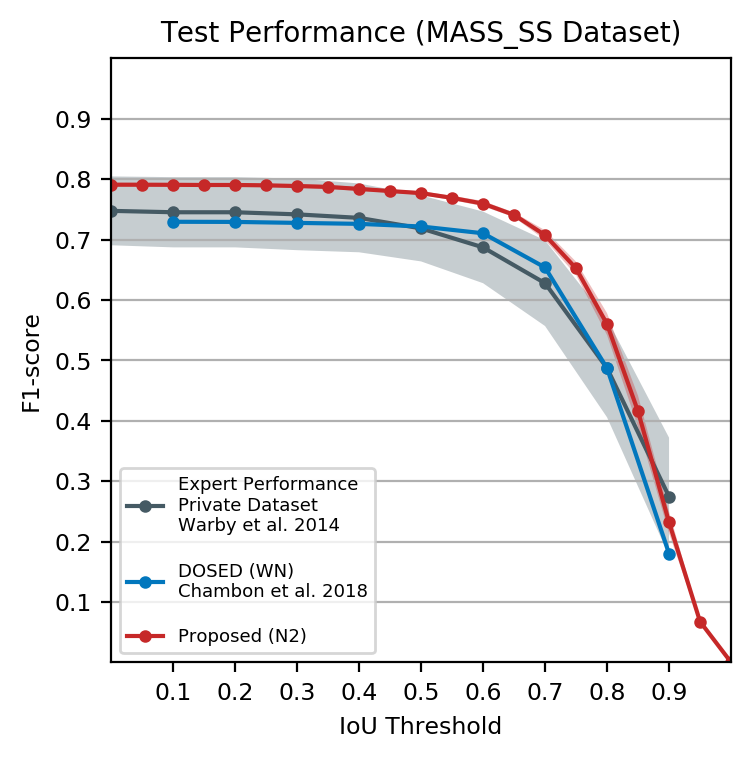

In [5]:
bsf_name = 'Proposed (%s)' % task_mode.upper()

compare_expert = True
compare_chambon = True
show_seed_std = True
alpha = 0.3
color_list = {'model_mean': CUSTOM_COLOR['red'] , 'expert': CUSTOM_COLOR['grey'], 'dosed': CUSTOM_COLOR['blue']}
linewidth_model = 1.5
markersize_model = 7
linewidth_others = 1.5
markersize_others = 7

# -------------------- P L O T ----------------------    

# Comparison data
compare_expert = (compare_expert and (dataset.event_name == constants.SPINDLE))
if compare_expert:
    expert_f1_curve_mean = np.loadtxt(os.path.join(COMPARISON_PATH, 'expert', 'ss_f1_vs_iou_expert_mean.csv'), delimiter=',')
    expert_f1_curve_std = np.loadtxt(os.path.join(COMPARISON_PATH, 'expert', 'ss_f1_vs_iou_expert_std.csv'), delimiter=',')
if compare_chambon and (dataset_name == constants.MASS_SS_NAME):
    dosed_f1_curve_wn = np.loadtxt(
        os.path.join(COMPARISON_PATH, 'dosed_paper', 'mass_ss_wn_f1_vs_iou_dosed_separately.csv'), delimiter=',')
if compare_chambon and (dataset_name == constants.MASS_KC_NAME):
    dosed_f1_curve_wn = np.loadtxt(
        os.path.join(COMPARISON_PATH, 'dosed_paper', 'mass_kc_wn_f1_vs_iou_dosed_separately.csv'), delimiter=',')
    
fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=DPI)


# Complete plot
if compare_expert:
    ax.plot(expert_f1_curve_mean[:, 0], expert_f1_curve_mean[:, 1], linewidth=linewidth_others, 
               markersize=markersize_others, marker='.', 
               label='Expert Performance\nPrivate Dataset\nWarby et al. 2014', color=color_list['expert'])
    ax.fill_between(
        expert_f1_curve_mean[:, 0], 
        expert_f1_curve_mean[:, 1] - expert_f1_curve_std[:, 1], 
        expert_f1_curve_mean[:, 1] + expert_f1_curve_std[:, 1], 
        alpha=alpha, facecolor=color_list['expert'])

if compare_chambon and (dataset_name in [constants.MASS_SS_NAME, constants.MASS_KC_NAME]):
    ax.plot(dosed_f1_curve_wn[:, 0], dosed_f1_curve_wn[:, 1], linewidth=linewidth_others, 
               markersize=markersize_others, marker='.', 
               label='DOSED (WN)\nChambon et al. 2018', color=color_list['dosed'])

ax.plot(iou_list, mean_f1_vs_iou, 
           linewidth=linewidth_model, markersize=markersize_model, marker='.', 
           label='%s' % bsf_name, color=color_list['model_mean'])
if show_seed_std:
    ax.fill_between(
        iou_list, 
        mean_f1_vs_iou - std_f1_vs_iou, 
        mean_f1_vs_iou + std_f1_vs_iou, 
        alpha=alpha, facecolor=color_list['model_mean'])

ax.set_title('Test Performance (%s Dataset)' % dataset_name.upper(), fontsize=10)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_yticks([0.1*i for i in range(1, 10)])
ax.set_xticks([0.1*i for i in range(1, 10)])
ax.tick_params(labelsize=8.5)
ax.set_xlabel('IoU Threshold', fontsize=8.5)
ax.set_ylabel('F1-score', fontsize=8.5)
ax.yaxis.grid()
ax.legend(loc='lower left', labelspacing=1.5, fontsize=6.5)

plt.show()

## Performance: Precision-Recall curve, average per set

In [6]:
iou_thr = 0.3
res_thr = 0.02
start_thr = 0.1
end_thr = 0.9
n_thr = int(np.round((end_thr - start_thr) / res_thr + 1))
thr_list = np.array([start_thr + res_thr * i for i in range(n_thr)])

pr_curve = {}
# Prepare expert labels
data_test = FeederDataset(
    dataset, test_ids, task_mode, which_expert=which_expert)
this_events = data_test.get_stamps()
for k in seed_id_list:
    print('Processing seed %d' % k, flush=True)
    # Columns are [x: recall, y: precision]
    pr_curve[k] = np.zeros((n_thr, 2))
    for i, thr in enumerate(thr_list):
        # Prepare model predictions
        prediction_test = predictions_dict[k][constants.TEST_SUBSET]
        prediction_test.set_probability_threshold(thr)
        this_detections = prediction_test.get_stamps()
        
        this_stats = [metrics.by_event_confusion(this_y, this_y_pred, iou_thr=iou_thr) 
                    for (this_y, this_y_pred) in zip(this_events, this_detections)]
        this_recall = np.mean([m[constants.RECALL] for m in this_stats])
        this_precision = np.mean([m[constants.PRECISION] for m in this_stats])
        pr_curve[k][i, 0] = this_recall
        pr_curve[k][i, 1] = this_precision

# Mean of runs
pr_curve['mean_runs'] = np.stack([pr_curve[k] for k in seed_id_list], axis=2).mean(axis=2)
print('Done', flush=True)

Processing seed 0
Processing seed 1
Processing seed 2
Processing seed 3
Done


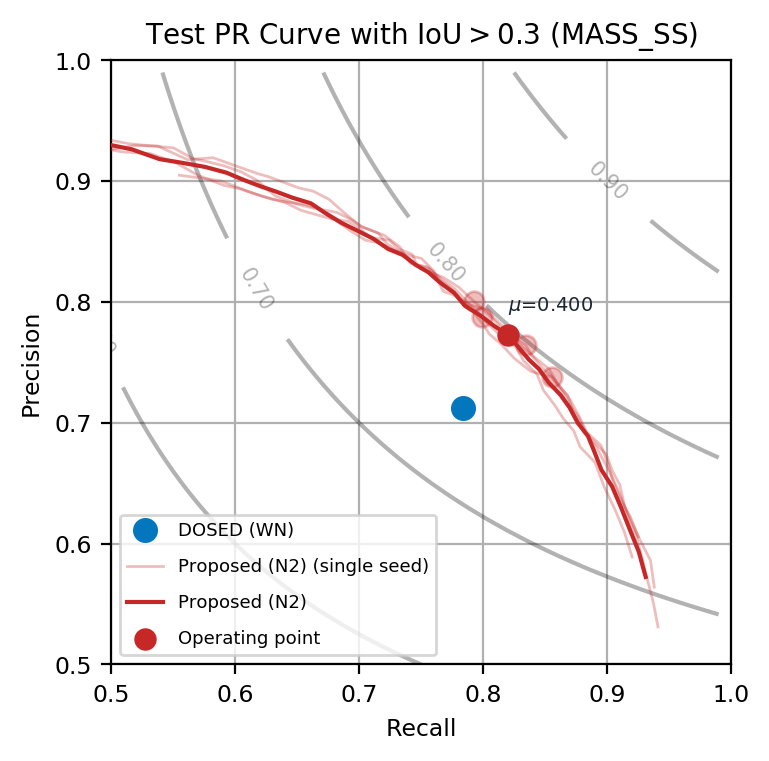

In [7]:
thr_run = optimal_xval_thr

# Plot 
fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=DPI)
markersize = 6
alpha = 0.3
text_space = 0.01
compare_chambon = True
show_seeds = True
color_list = {'model_mean': CUSTOM_COLOR['red'] , 'dosed': CUSTOM_COLOR['blue']}

# F1 score levels
delta = 0.01 
x_ = np.arange(1, 100) * delta 
y_ = np.arange(1, 100) * delta 
X, Y = np.meshgrid(x_, y_)
Z = 2 * X * Y / (X + Y)
CS = ax.contour(X, Y, Z, colors='k', alpha=0.3, levels=[0.6, 0.7, 0.8, 0.9])
ax.clabel(CS, fontsize=7.5, fmt='%1.2f')

# Chambon
if compare_chambon and (dataset_name == constants.MASS_SS_NAME):
    dosed_rec_prec_wn = np.loadtxt(
        os.path.join(COMPARISON_PATH, 'dosed_paper', 'mass_ss_wn_pr_dosed_separately.csv'), delimiter=',')
    ax.plot(dosed_rec_prec_wn[0], dosed_rec_prec_wn[1], 
           markersize=8, c=color_list['dosed'], zorder=10, 
            label='DOSED (WN)', marker='o', linestyle="None")
if compare_chambon and (dataset_name == constants.MASS_KC_NAME):
    dosed_rec_prec_wn = np.loadtxt(
        os.path.join(COMPARISON_PATH, 'dosed_paper', 'mass_kc_wn_pr_dosed_separately.csv'), delimiter=',')
    ax.plot(dosed_rec_prec_wn[0], dosed_rec_prec_wn[1], 
           markersize=8, c=color_list['dosed'], zorder=10, 
            label='DOSED (WN)', marker='o', linestyle="None")
    
if show_seeds:
    # Show single seeds
    seed_shown = False
    for k in seed_id_list:
        if not seed_shown:
            seed_shown=True
            label = '%s (single seed)' % bsf_name
        else:
            label = None
        ax.plot(pr_curve[k][:, 0], pr_curve[k][:, 1], 
            label=label,
            linewidth=1, color=color_list['model_mean'], zorder=7, alpha=alpha)
        
        chosen_thr_idx = np.where(np.isclose(thr_list, thr_run))[0].item()
        ax.scatter(pr_curve[k][chosen_thr_idx, 0], pr_curve[k][chosen_thr_idx, 1], 
                   s=50, c=color_list['model_mean'], zorder=7, alpha=alpha)
    
# Mean of runs
ax.plot(pr_curve['mean_runs'][:, 0], pr_curve['mean_runs'][:, 1], 
        label='%s' % bsf_name,
        linewidth=1.5, color=color_list['model_mean'], zorder=10)

# Highlight chosen operating point
chosen_thr_idx = np.where(np.isclose(thr_list, thr_run))[0].item()
ax.scatter(pr_curve['mean_runs'][chosen_thr_idx, 0], pr_curve['mean_runs'][chosen_thr_idx, 1], 
           s=50, c=color_list['model_mean'], zorder=10, label='Operating point')
ax.annotate('$\mu$=%1.3f' % thr_run, 
            (pr_curve['mean_runs'][chosen_thr_idx, 0], 
             pr_curve['mean_runs'][chosen_thr_idx, 1] + text_space*2), 
            fontsize=7, color='#1b2631', zorder=30)  

ax.set_title('Test PR Curve with IoU$>$%1.1f (%s)' % (iou_thr, dataset_name.upper()), fontsize=10)
ax.set_xlabel('Recall', fontsize=8.5)
ax.set_ylabel('Precision', fontsize=8.5)
ax.set_xlim([0.5, 1])
ax.set_ylim([0.5, 1])
ax.legend(loc='lower left', labelspacing=1, fontsize=6.5)
ax.tick_params(labelsize=8.5)
ax.grid()
plt.show()

## Performance: Precision-Recall plot, separated subjects

In [8]:
thr_run = optimal_xval_thr

iou_thr = 0.3

# Prepare model predictions
be_stats = {}
for k in seed_id_list:
    print('Processing seed %d' % k, flush=True)
    be_stats[k] = {}
    train_ids, val_ids = utils.split_ids_list(all_train_ids, seed=SEED_LIST[k], verbose=False)
    train_ids.sort()
    val_ids.sort()
    ids_per_set_dict = {
        constants.TRAIN_SUBSET: train_ids,
        constants.VAL_SUBSET: val_ids,
        constants.TEST_SUBSET: test_ids
    }
    for set_name in set_list:
        data_feeder = FeederDataset(
            dataset, ids_per_set_dict[set_name], task_mode, which_expert=which_expert)
        this_events = data_feeder.get_stamps()
        prediction_set = predictions_dict[k][set_name]
        prediction_set.set_probability_threshold(thr_run)
        this_detections = prediction_set.get_stamps()
        be_stats[k][set_name] = [
            metrics.by_event_confusion(this_y, this_y_pred, iou_thr=iou_thr) 
            for (this_y, this_y_pred) in zip(this_events, this_detections)]
print('Done')

Processing seed 0
Processing seed 1
Processing seed 2
Processing seed 3
Done


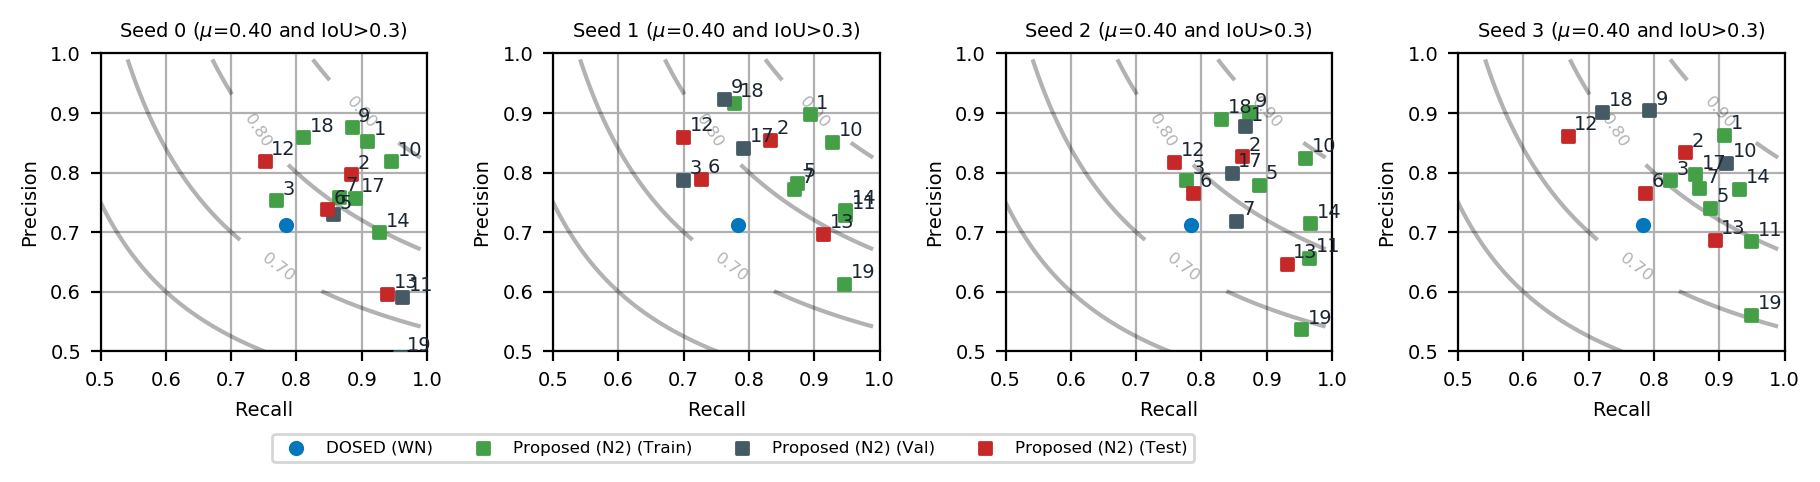

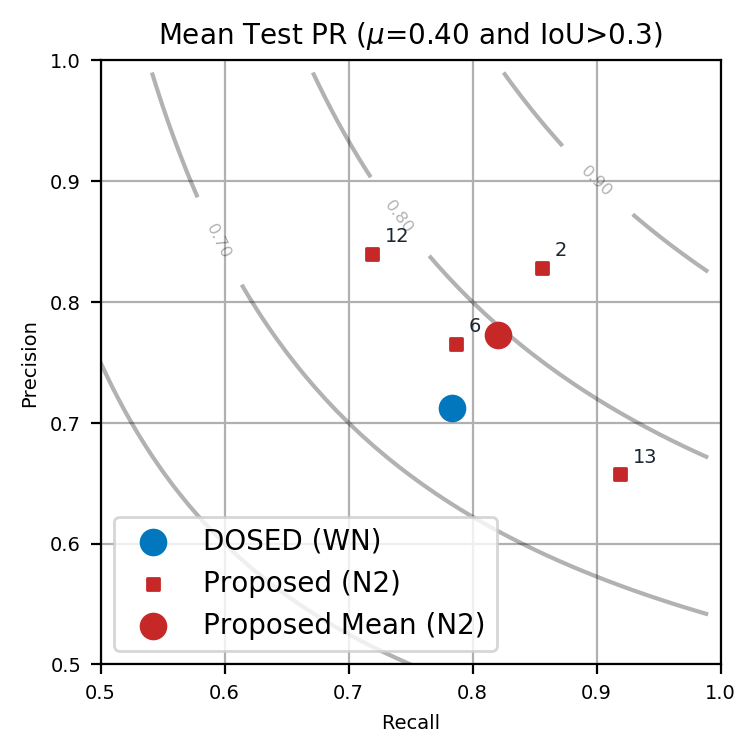

In [9]:
# Plot 
fig, ax = plt.subplots(1, n_seeds, figsize=(2.3*n_seeds, 2.3), dpi=DPI)
markersize = 20
alpha = 0.3
text_space = 0.01
compare_chambon = True
show_set_list = ['train', 'val', 'test']
color_list = {'train': CUSTOM_COLOR['green'] , 'val': CUSTOM_COLOR['grey'], 'test': CUSTOM_COLOR['red'], 'dosed': CUSTOM_COLOR['blue']}

# F1 score levels
delta = 0.01 
x_ = np.arange(1, 100) * delta 
y_ = np.arange(1, 100) * delta 
X, Y = np.meshgrid(x_, y_)
Z = 2 * X * Y / (X + Y)

# Chambon
if compare_chambon and (dataset_name == constants.MASS_SS_NAME):
    dosed_rec_prec_wn = np.loadtxt(
        os.path.join(COMPARISON_PATH, 'dosed_paper', 'mass_ss_wn_pr_dosed_separately.csv'), delimiter=',')
if compare_chambon and (dataset_name == constants.MASS_KC_NAME):
    dosed_rec_prec_wn = np.loadtxt(
        os.path.join(COMPARISON_PATH, 'dosed_paper', 'mass_kc_wn_pr_dosed_separately.csv'), delimiter=',')
    
for j in range(n_seeds):
    seed_id = seed_id_list[j]
    train_ids, val_ids = utils.split_ids_list(all_train_ids, seed=SEED_LIST[seed_id], verbose=False)
    train_ids.sort()
    val_ids.sort()
    ids_per_set_dict = {
        constants.TRAIN_SUBSET: train_ids,
        constants.VAL_SUBSET: val_ids,
        constants.TEST_SUBSET: test_ids
    }
    
    CS = ax[j].contour(X, Y, Z, colors='k', alpha=0.3, levels=[0.6, 0.7, 0.8, 0.9])
    ax[j].clabel(CS, fontsize=6, fmt='%1.2f')
    
    if compare_chambon and (dataset_name in [constants.MASS_SS_NAME, constants.MASS_KC_NAME]):
        ax[j].scatter(
            dosed_rec_prec_wn[0], dosed_rec_prec_wn[1], 
            c=color_list['dosed'], 
            label='DOSED (WN)', marker='o',
            s=markersize, zorder=10)
    
    for set_name in set_list:
        if set_name in show_set_list:
            for i, stats in enumerate(be_stats[seed_id][set_name]):
                if i==0:
                    label = 'Proposed (%s) (%s)' % (task_mode.upper(), set_name.capitalize())
                else:
                    label = None
                ax[j].scatter(
                    stats['recall'], stats['precision'], 
                    c=color_list[set_name], 
                    label=label, marker='s',
                    s=markersize, zorder=10)
                ax[j].annotate(
                    ids_per_set_dict[set_name][i], 
                    (stats['recall']+text_space, stats['precision']+text_space), 
                    fontsize=7, color='#1b2631', zorder=20) 
    ax[j].set_title('Seed %d ($\mu$=%1.2f and IoU>%1.1f)' % (seed_id, thr_run, iou_thr), fontsize=7)
    ax[j].set_xlabel('Recall', fontsize=7)
    ax[j].set_ylabel('Precision', fontsize=7)
    ax[j].set_xlim([0.5, 1])
    ax[j].set_ylim([0.5, 1])
    ax[j].tick_params(labelsize=7)
    ax[j].grid()

plt.tight_layout()
ax[0].legend(loc='lower left', bbox_to_anchor=(0.5, -0.4), labelspacing=1, fontsize=6, ncol=(1 + len(show_set_list)))
plt.show()


# mean test
fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=DPI)
    
CS = ax.contour(X, Y, Z, colors='k', alpha=0.3, levels=[0.6, 0.7, 0.8, 0.9])
ax.clabel(CS, fontsize=6, fmt='%1.2f')

if compare_chambon and (dataset_name in [constants.MASS_SS_NAME, constants.MASS_KC_NAME]):
    ax.scatter(
        dosed_rec_prec_wn[0], dosed_rec_prec_wn[1], 
        c=color_list['dosed'], 
        label='DOSED (WN)', marker='o',
        s=markersize*4, zorder=10)

set_name = constants.TEST_SUBSET

recall_list = []
precision_list = []
for i in range(len(test_ids)):

    recall_mean = np.stack([be_stats[k][set_name][i]['recall'] for k in seed_id_list]).mean()
    precision_mean = np.stack([be_stats[k][set_name][i]['precision'] for k in seed_id_list]).mean()
    recall_list.append(recall_mean)
    precision_list.append(precision_mean)
    if i==0:
        label = 'Proposed (%s)' % task_mode.upper()
    else:
        label = None
    ax.scatter(
        recall_mean, precision_mean, 
        c=color_list[set_name], 
        label=label, marker='s',
        s=markersize, zorder=10)
    ax.annotate(
        ids_per_set_dict[set_name][i], 
        (recall_mean+text_space, precision_mean+text_space), 
        fontsize=7, color='#1b2631', zorder=20)

# mean of subjects

ax.scatter(
    np.mean(recall_list), np.mean(precision_list), 
    c=color_list[set_name], 
    label='Proposed Mean (%s)' % task_mode.upper(), marker='o',
    s=markersize*4, zorder=10)
    
ax.set_title('Mean Test PR ($\mu$=%1.2f and IoU>%1.1f)' % (thr_run, iou_thr), fontsize=10)
ax.set_xlabel('Recall', fontsize=7)
ax.set_ylabel('Precision', fontsize=7)
ax.set_xlim([0.5, 1])
ax.set_ylim([0.5, 1])
ax.tick_params(labelsize=7)
ax.grid()
ax.legend(loc='lower left')
plt.show()

## Visualization of subject

In [ ]:
thr = optimal_thr

subset_name = 'test'
subject_id = 2

# -----
idx_dict = {'train': train_ids, 'val': val_ids, 'test': test_ids, 'alltrain': all_train_ids}
idx_subject = idx_dict[subset_name].index(subject_id)
this_signal = x[subset_name][idx_subject]
this_marks_1 = y[subset_name][idx_subject]
this_n2_pages = pages[subset_name][idx_subject]
this_prob = y_pred[subset_name][idx_subject]
if dataset_name == constants.MASS_NAME:
    if (subject_id not in [4, 8, 15, 16]):
        _, this_marks_2 = dataset.get_subject_data(subject_id, which_expert=2, verbose=True)
    channel_name = 'C3-CLE'
    event_name = 'Sleep Spindle'
elif dataset_name == constants.INTA_NAME:
    channel_name = 'F4-C4'
    event_name = 'Sleep Spindle'
else:
    channel_name = 'C3-CLE'
    event_name = 'K Complex'
    
y_pred_thr = postprocessing.generate_mark_intervals(
    y_pred[subset_name][idx_subject], pages[subset_name][idx_subject], 200//8, 200, thr=thr,
    min_separation=min_separation, min_duration=min_duration, max_duration=max_duration
)
y_pred_thr_seq = data_ops.inter2seq(y_pred_thr, 0, (pages[subset_name][idx_subject].max()+1)*200*20-1)
# Now reshape into pages
this_det = data_ops.extract_pages(y_pred_thr_seq, pages[subset_name][idx_subject], 200*20, border_size=0)
    
# make a color map of fixed colors
cmap = colors.ListedColormap(['white', '#c62828'])

def plot_page(page_idx):
    if (dataset_name == constants.MASS_NAME) and (subject_id not in [4, 8, 15, 16]):
        fig = plt.figure(figsize=(15, 4), dpi=DPI)
        gs = gridspec.GridSpec(3, 1, height_ratios=[4, 1, 1])
    else:
        fig = plt.figure(figsize=(15, 3), dpi=DPI)
        gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1])
    
    page_idx = page_idx - 1
    
    segment_signal = this_signal[page_idx, :]
    segment_marks_1 = this_marks_1[page_idx, :]
    segment_prob = this_prob[page_idx, :]
    segment_det = this_det[page_idx, :]
    time_axis = np.arange(this_signal.shape[1]) / dataset.fs
    
    if (dataset_name == constants.MASS_NAME) and (subject_id not in [4, 8, 15, 16]):
        segment_marks_2 = this_marks_2[page_idx, :]
    
    gs_idx = 0
    
    # Signal
    y_max = 10
    ax = fig.add_subplot(gs[gs_idx])
    gs_idx = gs_idx + 1
    ax.plot(time_axis, segment_signal, linewidth=1, color='#455a64', label='EEG %s' % channel_name)
    ax.fill_between(time_axis, y_max * segment_marks_1, -y_max * segment_marks_1, facecolor='#c62828', alpha=0.3, label=event_name)
    ax.set_yticks([])
    ax.set_xlim([0, 20])
    ax.set_ylim([-y_max, y_max])
    ax.set_title('Subject %d (%s-%s). Page in record: %d (intervals of 0.5s are shown).' 
                 % (subject_id, dataset_name.upper(), subset_name.capitalize(), this_n2_pages[page_idx]), fontsize=10)
    ax.set_xticks([0, 5, 10, 15, 20])
    ax.set_xticks(np.arange(0, 20, 0.5), minor=True)
    ax.grid(b=True, axis='x', which='minor')
    lg = ax.legend(loc='upper right', fontsize=8.5)
    # lh = lg.legendHandles[1]
    # lh.set_facecolor(lh.get_facecolor())
    # lh.set_alpha(1.0)
    ax.tick_params(labelsize=8.5)
    
    # Neural net
    delta_y = 0.1
    time_axis_short = time_axis[::8]
    ax = fig.add_subplot(gs[gs_idx])
    gs_idx = gs_idx + 1
    ax.plot(time_axis_short, segment_prob, color='#c62828', linewidth=1.5, zorder=7)
    ax.fill_between(time_axis, (1+delta_y)*segment_det, (-delta_y)*segment_det, facecolor='grey', zorder=6)
    ax.set_xticks([])
    ax.set_ylim([-delta_y, 1+delta_y])
    ax.set_xlim([0, 20])
    ax.set_yticks([0, 1])
    ax.set_yticks([thr], minor=True)
    ax.grid(b=True, axis='y', linewidth=1.5, which='minor', zorder=5)
    ax.tick_params(labelsize=8.5)
    ax.set_title('Model probability prediction (%1.2f threshold and postprocessed detections are shown)' % thr, fontsize=10)
    
    if dataset_name == constants.MASS_NAME and (subject_id not in [4, 8, 15, 16]):
        ax = fig.add_subplot(gs[gs_idx])
        ax.imshow(segment_marks_2[np.newaxis, :], interpolation=None, aspect='auto', cmap=cmap)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title('Second expert, not used for training (red indicates event)', fontsize=10)
    
    plt.tight_layout()
    plt.show()

In [ ]:
widgets.interact(
    lambda page_idx: plot_page(page_idx),
    page_idx=widgets.IntSlider(min=1,max=this_n2_pages.shape[0],step=1,value=1, continuous_update=False));

# Error analysis

### Postprocessing sensitivity

In [ ]:
chosen_set_error = 'test'
thr = optimal_thr

y_thr = y_stamps[chosen_set_error]

# Prepare model predictions
n_subjects = len(y_thr)
pred_stamps = []
for i in range(n_subjects):
    print('Processing subject %d/%d' % (i+1, n_subjects), flush=True)
    # Binarize
    this_y_pred_thr = (y_pred[chosen_set_error][i] >= thr).astype(np.int32)
    # Transform to intervals
    this_y_pred_thr = data_ops.seq2inter_with_pages(
        this_y_pred_thr, pages[chosen_set_error][i]
    )
    pred_stamps.append(this_y_pred_thr)
fs_pred = 200 // 8 
fs_real = 200
print('Done')

In [ ]:
# ------------------------- Compute spacing ----------------------
combine_thr = 0.3

spacing = []
spacing_expert = []
for i in range(n_subjects):
    print('Spacing for subject %d/%d' % (i+1, n_subjects), flush=True)
    this_spacing = (pred_stamps[i][1:, 0] - pred_stamps[i][:-1, 1]) / fs_pred
    this_spacing_expert = (y_stamps[chosen_set_error][i][1:, 0] - y_stamps[chosen_set_error][i][:-1, 1]) / fs_real
    # Only consider for this analysis, spacing less than one second
    this_spacing = this_spacing[this_spacing < 1]
    this_spacing_expert = this_spacing_expert[this_spacing_expert < 1]
    spacing.append(this_spacing)
    spacing_expert.append(this_spacing_expert)
print('Done')

fig, ax = plt.subplots(n_subjects, 2, figsize=(8, 1*n_subjects), dpi=DPI, sharex=True, sharey=False)
ax[0, 0].set_title('Spacing between nearby expert marks', fontsize=10)
ax[0, 1].set_title('Spacing between nearby detections', fontsize=10)
y_max = 0
idx_dict = {'train': train_ids, 'val': val_ids, 'test': test_ids}
for i in range(n_subjects):
    subject_idx = idx_dict[chosen_set_error][i]
    # Real
    n_real, _, _ = ax[i, 0].hist(spacing_expert[i], bins=[k*0.1 for k in range(11)], color='#455a64', label='S%02d (%s)' % (subject_idx, chosen_set_error.capitalize()))
    ax[i, 0].set_xticks([k*0.2 for k in range(6)])
    ax[i, 0].tick_params(labelsize=8.5)
    ax[i, 0].legend(fontsize=8.5)
    # Predicted
    n_pred, _, _ = ax[i, 1].hist(spacing[i], bins=[k*0.1 for k in range(11)], color='#c62828', label='S%02d (%s)' % (subject_idx, chosen_set_error.capitalize()))
    ax[i, 1].set_xticks([k*0.2 for k in range(6)])
    ax[i, 1].tick_params(labelsize=8.5)
    ax[i, 1].legend(fontsize=8.5)
    max_y = max(np.max(n_real), np.max(n_pred))
    ax[i, 0].plot([combine_thr, combine_thr], [0, max_y], '--', color='k', linewidth=2, alpha=0.6)
    ax[i, 1].plot([combine_thr, combine_thr], [0, max_y], '--', color='k', linewidth=2, alpha=0.6)
    # y_max = max(max_y, y_max)
# for i in range(n_subjects):
#     ax[i, 0].plot([combine_thr, combine_thr], [0, y_max], '--', color='k', linewidth=2, alpha=0.6)
#     ax[i, 1].plot([combine_thr, combine_thr], [0, y_max], '--', color='k', linewidth=2, alpha=0.6)
ax[-1, 0].set_xlabel('Spacing [s]', fontsize=8.5)
ax[-1, 1].set_xlabel('Spacing [s]', fontsize=8.5)
plt.show()

In [ ]:
# -------------- Durations

if dataset_name == constants.MASSK_NAME:
    postprocess_predicted = False
else:
    postprocess_predicted = True

durations = []
durations_expert = []
for i in range(n_subjects):
    print('Durations for subject %d/%d' % (i+1, n_subjects), flush=True)
    # First, combine close marks
    if dataset_name == constants.MASSK_NAME:
        this_pred_stamps = pred_stamps[i]
    else:
        this_pred_stamps = postprocessing.combine_close_marks(pred_stamps[i], fs_pred, combine_thr)
    # Now compute durations
    this_durations = (this_pred_stamps[:, 1] - this_pred_stamps[:, 0]) / fs_pred
    this_durations_expert = (y_stamps[chosen_set_error][i][:, 1] - y_stamps[chosen_set_error][i][:, 0]) / fs_real
    # Only consider for this analysis, spacing less than one second
    durations.append(this_durations)
    durations_expert.append(this_durations_expert)
print('Done')

fig, ax = plt.subplots(n_subjects, 2, figsize=(8, 1*n_subjects), dpi=DPI, sharex=True, sharey=False)
ax[0, 0].set_title('Duration of expert marks', fontsize=10)
ax[0, 1].set_title('Duration of detections', fontsize=10)
idx_dict = {'train': train_ids, 'val': val_ids, 'test': test_ids}
y_max = 0
min_duration = 0.3  
for i in range(n_subjects):
    subject_idx = idx_dict[chosen_set_error][i]
    # Real
    n_real, _, _ = ax[i, 0].hist(durations_expert[i], color='#455a64', label='S%02d (%s)' % (subject_idx, chosen_set_error.capitalize()))
    ax[i, 0].tick_params(labelsize=8.5)
    ax[i, 0].legend(fontsize=8.5)
    # Predicted
    n_pred, _, _ = ax[i, 1].hist(durations[i], color='#c62828', label='S%02d (%s)' % (subject_idx, chosen_set_error.capitalize()))
    ax[i, 1].tick_params(labelsize=8.5)
    ax[i, 1].legend(fontsize=8.5)
    max_y = max(np.max(n_real), np.max(n_pred))
    ax[i, 0].plot([min_duration, min_duration], [0, max_y], '--', color='k', linewidth=2, alpha=0.6)
    ax[i, 1].plot([min_duration, min_duration], [0, max_y], '--', color='k', linewidth=2, alpha=0.6)
    y_max = max(max_y, y_max)
    print(durations[i].max())
    
#for i in range(n_subjects):
#    ax[i, 0].plot([min_duration, min_duration], [0, y_max], '--', color='k', linewidth=2, alpha=0.6)
#    ax[i, 1].plot([min_duration, min_duration], [0, y_max], '--', color='k', linewidth=2, alpha=0.6)

ax[-1, 0].set_xlabel('Duration [s]', fontsize=8.5)
ax[-1, 1].set_xlabel('Duration [s]', fontsize=8.5)
plt.show()

### Location of Falses

In [ ]:
if dataset_name == constants.MASSK_NAME:
    min_separation = 0
    min_duration = 0.3
    max_duration = 4.0
else:
    min_separation = 0.3
    min_duration = 0.2
    max_duration = 4.0

iou_array = []
idx_array = []
y_pred_thr = []
for i in range(n_subjects):
    print('Processing subject %d/%d' % (i+1, n_subjects), flush=True)
    events = y_stamps[chosen_set_error][i]
    detections = postprocessing.generate_mark_intervals(
        y_pred[chosen_set_error][i], pages[chosen_set_error][i], 200//8, 200, thr=thr, 
        min_separation=min_separation, min_duration=min_duration, max_duration=max_duration)
    print(events.shape, detections.shape)
    this_iou_array, this_idx_array = metrics.matching(events, detections)
    iou_array.append(this_iou_array)
    idx_array.append(this_idx_array)
    y_pred_thr.append(detections)
print('Done')

In [ ]:
# --- False negatives
iou_thr = 0.3

fn_center = []
for i in range(n_subjects):
    idx_fn = iou_array[i] < iou_thr
    fn_stamps = y_stamps[chosen_set_error][i][idx_fn]
    this_fn_center = np.mean(fn_stamps, axis=1).astype(np.int32)
    fn_center.append(this_fn_center)
    
# --- False positives
fp_center = []
for i in range(n_subjects):
    # matched detections:
    idx_fp_1 = iou_array[i] < iou_thr
    idx_fp_1 = idx_array[i][idx_fp_1]
    idx_fp_1 = [idx for idx in idx_fp_1 if idx != -1]
    # Unmatched events
    n_detections = y_pred_thr[i].shape[0]
    idx_fp_2 = [idx for idx in range(n_detections) if (idx not in idx_array[i])]
    idx_fp = idx_fp_1 + idx_fp_2
    fp_stamps = y_pred_thr[i][idx_fp]
    this_fp_center = np.mean(fp_stamps, axis=1).astype(np.int32)
    fp_center.append(this_fp_center)

    
# --- Histogram of IoU values across real events
fig, ax = plt.subplots(n_subjects, 1, figsize=(3.5, 1*n_subjects), dpi=DPI, sharex=True, sharey=False)
ax[0].set_title('IoU values on expert marks', fontsize=10)
idx_dict = {'train': train_ids, 'val': val_ids, 'test': test_ids}
for i in range(n_subjects):
    subject_idx = idx_dict[chosen_set_error][i]
    ax[i].hist(iou_array[i], color='#455a64', label='S%02d (%s)' % (subject_idx, chosen_set_error.capitalize()), bins=[0.05*i for i in range(21)])
    ax[i].tick_params(labelsize=8.5)
    ax[i].legend(fontsize=8.5, loc='upper center')
    ax[i].set_xticks([0.2*i for i in range(6)])
ax[-1].set_xlabel('Time within page [s]', fontsize=8.5)
plt.show()
    
# --- Location in page
fn_loc_page = [np.mod(this_fn_center, 20*fs_real) for this_fn_center in fn_center]

fig, ax = plt.subplots(n_subjects, 2, figsize=(8, 1*n_subjects), dpi=DPI, sharex=True, sharey=False)
ax[0, 0].set_title('Location of expert marks with IoU < %1.2f' % (iou_thr), fontsize=11)

idx_dict = {'train': train_ids, 'val': val_ids, 'test': test_ids}
for i in range(n_subjects):
    subject_idx = idx_dict[chosen_set_error][i]
    ax[i, 0].hist(fn_loc_page[i] / fs_real, bins=[i*4 for i in range(6)], color='#455a64', label='S%02d (%s)' % (subject_idx, chosen_set_error.capitalize()))
    ax[i, 0].tick_params(labelsize=8.5)
    ax[i, 0].legend(fontsize=8.5, loc='upper center')
ax[-1, 0].set_xticks([i*4 for i in range(6)])
ax[-1, 0].set_xlabel('Time within page [s]', fontsize=8.5)

fp_loc_page = [np.mod(this_fp_center, 20*fs_real) for this_fp_center in fp_center]

ax[0, 1].set_title('Location of detections with IoU < %1.2f' % (iou_thr), fontsize=10)

idx_dict = {'train': train_ids, 'val': val_ids, 'test': test_ids}
for i in range(n_subjects):
    subject_idx = idx_dict[chosen_set_error][i]
    ax[i, 1].hist(fp_loc_page[i] / fs_real, bins=[i*4 for i in range(6)], color='#c62828', label='S%02d (%s)' % (subject_idx, chosen_set_error.capitalize()))
    ax[i, 1].tick_params(labelsize=8.5)
    ax[i, 1].legend(fontsize=8.5, loc='upper center')
ax[-1, 1].set_xticks([i*4 for i in range(6)])
ax[-1, 1].set_xlabel('Time within page [s]', fontsize=8.5)

plt.show()

# --- Location in register

fn_loc_register = [np.floor_divide(this_fn_center, 20*fs_real) for this_fn_center in fn_center]
max_page_array = [np.max(pages[chosen_set_error][i]) for i in range(n_subjects)]

max_of_all = np.max(max_page_array)

fig, ax = plt.subplots(n_subjects, 2, figsize=(8, 1*n_subjects), dpi=DPI, sharex=True, sharey=False)
ax[0, 0].set_title('Location in register of expert marks with IoU < %1.1f' % (iou_thr), fontsize=10)

idx_dict = {'train': train_ids, 'val': val_ids, 'test': test_ids}
for i in range(n_subjects):
    subject_idx = idx_dict[chosen_set_error][i]
    ax[i, 0].hist(fn_loc_register[i], color='#455a64', label='S%02d (%s)' % (subject_idx, chosen_set_error.capitalize()))
    ax[i, 0].tick_params(labelsize=8.5)
    ax[i, 0].legend(fontsize=8.5)
ax[-1, 0].set_xlim([0, max_of_all+10])
ax[-1, 0].set_xlabel('Page within register', fontsize=8.5)

fp_loc_register = [np.floor_divide(this_fp_center, 20*fs_real) for this_fp_center in fp_center]
max_page_array = [np.max(pages[chosen_set_error][i]) for i in range(n_subjects)]

max_of_all = np.max(max_page_array)

ax[0, 1].set_title('Location in register of detections with IoU < %1.1f' % (iou_thr), fontsize=11)

idx_dict = {'train': train_ids, 'val': val_ids, 'test': test_ids}
for i in range(n_subjects):
    subject_idx = idx_dict[chosen_set_error][i]
    ax[i, 1].hist(fp_loc_register[i], color='#c62828', label='S%02d (%s)' % (subject_idx, chosen_set_error.capitalize()))
    ax[i, 1].tick_params(labelsize=8.5)
    ax[i, 1].legend(fontsize=8.5)
ax[-1, 1].set_xlim([0, max_of_all+10])
ax[-1, 1].set_xlabel('Page within register', fontsize=8.5)

plt.show()

# ----- N2 pages

fig, ax = plt.subplots(n_subjects, 1, figsize=(3.5, 1*n_subjects), dpi=DPI, sharex=True, sharey=True)
ax[0].set_title('Location in register of N2 pages (%s)' % (chosen_set_error.capitalize()), fontsize=10)
idx_dict = {'train': train_ids, 'val': val_ids, 'test': test_ids}
for i in range(n_subjects):
    subject_idx = idx_dict[chosen_set_error][i]
    ax[i].hist(pages[chosen_set_error][i], color='#455a64', label='S%02d (%s)' % (subject_idx, chosen_set_error.capitalize()))
    ax[i].tick_params(labelsize=8.5)
    ax[i].legend(fontsize=8.5)
ax[-1].set_xlim([0, max_of_all+10])
ax[-1].set_xlabel('Page within register', fontsize=8.5)

plt.show()

### IoU vs Duration

In [ ]:
# --- Scatter of IoU values and duration of real and detected events
alpha = 0.2
markersize=10

fig, ax = plt.subplots(n_subjects, 2, figsize=(7, 1*n_subjects), dpi=DPI, sharex=True, sharey=True)
ax[0, 0].set_title('IoU vs duration of expert marks', fontsize=10)
idx_dict = {'train': train_ids, 'val': val_ids, 'test': test_ids}
for i in range(n_subjects):
    subject_idx = idx_dict[chosen_set_error][i]
    # Now compute durations
    this_durations_expert = (y_stamps[chosen_set_error][i][:, 1] - y_stamps[chosen_set_error][i][:, 0]) / fs_real
    ax[i, 0].scatter(this_durations_expert, iou_array[i], label='S%02d (%s)' % (subject_idx, chosen_set_error.capitalize()), color='#455a64', alpha=alpha, s=markersize)
    ax[i, 0].tick_params(labelsize=8.5)
    lg = ax[i, 0].legend(fontsize=7, loc='upper right')
    for lh in lg.legendHandles:
        lh.set_facecolor(lh.get_facecolor())
        lh.set_edgecolor(lh.get_edgecolor())
        lh.set_alpha(1.0)
    ax[i, 0].set_ylabel('IoU', fontsize=8.5)
ax[-1, 0].set_xlabel('Duration [s]', fontsize=8.5)

ax[0, 1].set_title('IoU vs duration of detections', fontsize=10)
for i in range(n_subjects):
    subject_idx = idx_dict[chosen_set_error][i]
    # Now compute durations for IoU > 0 
    idx_valid = (idx_array[i] > -1)
    this_iou_1 = iou_array[i][idx_valid]
    y_pred_stamps = y_pred_thr[i][idx_array[i]][idx_valid]
    this_durations_1 = (y_pred_stamps[:, 1] - y_pred_stamps[:, 0]) / fs_real
    # Now durations for IoU = 0
    n_detections = y_pred_thr[i].shape[0]
    idx_fp_2 = [idx for idx in range(n_detections) if (idx not in idx_array[i])]
    y_pred_stamps = y_pred_thr[i][idx_fp_2]
    this_durations_2 = (y_pred_stamps[:, 1] - y_pred_stamps[:, 0]) / fs_real
    this_iou_2 = np.zeros(this_durations_2.shape[0])
    # Concatenation
    this_durations = np.concatenate([this_durations_1, this_durations_2])
    this_iou = np.concatenate([this_iou_1, this_iou_2])
    ax[i, 1].scatter(this_durations, this_iou, label='S%02d (%s)' % (subject_idx, chosen_set_error.capitalize()), color='#c62828', alpha=alpha, s=markersize)
    ax[i, 1].tick_params(labelsize=8.5)
    lg = ax[i, 1].legend(fontsize=7, loc='upper right')
    for lh in lg.legendHandles:
        lh.set_facecolor(lh.get_facecolor())
        lh.set_edgecolor(lh.get_edgecolor())
        lh.set_alpha(1.0)
    # ax[i, 1].set_ylabel('IoU', fontsize=8.5)
ax[-1, 1].set_xlabel('Duration [s]', fontsize=8.5)

plt.show()


# --- Histogram of duration for IoU == 0
fig, ax = plt.subplots(n_subjects, 2, figsize=(8, 1*n_subjects), dpi=DPI, sharex=True, sharey=False)
ax[0, 0].set_title('Duration of unpaired expert marks', fontsize=10)
idx_dict = {'train': train_ids, 'val': val_ids, 'test': test_ids}
for i in range(n_subjects):
    subject_idx = idx_dict[chosen_set_error][i]
    # Now compute durations
    this_durations_expert = (y_stamps[chosen_set_error][i][:, 1] - y_stamps[chosen_set_error][i][:, 0]) / fs_real
    idx_zero = (iou_array[i] == 0)
    this_durations_expert_fn = this_durations_expert[idx_zero]
    ax[i, 0].hist(this_durations_expert_fn, label='S%02d (%s)' % (subject_idx, chosen_set_error.capitalize()), color='#455a64')
    ax[i, 0].tick_params(labelsize=8.5)
    lg = ax[i, 0].legend(fontsize=8.5, loc='upper right')
    
ax[-1, 0].set_xlabel('Duration [s]', fontsize=8.5)

ax[0, 1].set_title('Duration of unpaired detections', fontsize=10)
for i in range(n_subjects):
    subject_idx = idx_dict[chosen_set_error][i]
    n_detections = y_pred_thr[i].shape[0]
    idx_fp_2 = [idx for idx in range(n_detections) if (idx not in idx_array[i])]
    y_pred_stamps = y_pred_thr[i][idx_fp_2]
    this_durations_fp = (y_pred_stamps[:, 1] - y_pred_stamps[:, 0]) / fs_real
    ax[i, 1].hist(this_durations_fp, label='S%02d (%s)' % (subject_idx, chosen_set_error.capitalize()), color='#c62828')
    ax[i, 1].tick_params(labelsize=8.5)
    ax[i, 1].legend(fontsize=8.5, loc='upper right')
ax[-1, 1].set_xlabel('Duration [s]', fontsize=8.5)

plt.show()


### Duration of events and matched detections

In [ ]:
alpha = 0.2

fig, ax = plt.subplots(2, 2, figsize=(5, 5), dpi=DPI, sharex=False, sharey=False)
# plt.suptitle('Duration of matched events (%s)' % (chosen_set_error.capitalize()), fontsize=11)
idx_dict = {'train': train_ids, 'val': val_ids, 'test': test_ids}
for i in range(n_subjects):
    subject_idx = idx_dict[chosen_set_error][i]
    idx_valid = (idx_array[i] > -1)
    # Now compute durations for real
    this_durations_expert = (y_stamps[chosen_set_error][i][:, 1] - y_stamps[chosen_set_error][i][:, 0]) / fs_real
    this_durations_expert = this_durations_expert[idx_valid]
    # Now compute durations for matched detections
    y_pred_stamps = y_pred_thr[i][idx_array[i]][idx_valid]
    this_durations_det = (y_pred_stamps[:, 1] - y_pred_stamps[:, 0]) / fs_real
    if i<2:
        ax[0, i].scatter(this_durations_expert, this_durations_det, label='S%02d' % subject_idx, color='#455a64', alpha=alpha)
        ax[0, i].tick_params(labelsize=8.5)
        lg = ax[0, i].legend(fontsize=7)
        for lh in lg.legendHandles:
            lh.set_facecolor(lh.get_facecolor())
            lh.set_edgecolor(lh.get_edgecolor())
            lh.set_alpha(1.0)
        max_dur = max(this_durations_expert.max(), this_durations_det.max())
        ax[0, i].set_xlim([0, max_dur + 0.1])
        ax[0, i].set_ylim([0, max_dur + 0.1])
        if i == 0 :
            ax[0, i].set_ylabel('Detected duration [s]', fontsize=8.5)
        # ax[0, i].set_xlabel('Duration Real [s]', fontsize=8.5)
        ax[0, i].plot([0.3, 2.0], [0.3, 2.0], '--k', alpha=0.6)
    else:
        ax[1, i-2].scatter(this_durations_expert, this_durations_det, label='S%02d' % subject_idx, color='#455a64', alpha=alpha)
        ax[1, i-2].tick_params(labelsize=8.5)
        lg = ax[1, i-2].legend(fontsize=7)
        for lh in lg.legendHandles:
            lh.set_facecolor(lh.get_facecolor())
            lh.set_edgecolor(lh.get_edgecolor())
            lh.set_alpha(1.0)
        max_dur = max(this_durations_expert.max(), this_durations_det.max())
        ax[1, i-2].set_xlim([0, max_dur + 0.1])
        ax[1, i-2].set_ylim([0, max_dur + 0.1])
        if i == 2:
            ax[1, i-2].set_ylabel('Detected duration [s]', fontsize=8.5)
        ax[1, i-2].set_xlabel('Real duration [s]', fontsize=8.5)
        ax[1, i-2].plot([0.3, 2.0], [0.3, 2.0], '--k', alpha=0.6)

plt.tight_layout()
plt.show()

### Predicted probability to matched and unmatched events

In [ ]:
# Prepare probabilities
whole_y_proba = []
for i in range(n_subjects):
    this_proba = y_pred[chosen_set_error][i]
    this_pages = pages[chosen_set_error][i]
    page_size = this_proba.shape[1]
    max_page = np.max(this_pages)
    max_size = (max_page + 1) * page_size
    whole_y_proba.append(np.zeros(max_size, dtype=np.float32))
    for k, page in enumerate(this_pages):
        sample_start = page * page_size
        sample_end = (page + 1) * page_size
        whole_y_proba[i][sample_start:sample_end] = this_proba[k, :]

In [ ]:
# Matching probabilities (Candidates for TP according to IoU)
# It is expected that they have more than 0.5 since that is the threshold used for detection
print('Processing probability for matched events', flush=True)
matching_proba = []
for i in range(n_subjects):
    subject_idx = idx_dict[chosen_set_error][i]
    # In this case, we look for the valid detections stamps 
    idx_valid = (idx_array[i] > -1)
    y_pred_stamps = y_pred_thr[i][idx_array[i]][idx_valid]
    # And now we need to get the probabilities inside those stamps
    # First, we downsample the stamps
    y_pred_stamps = y_pred_stamps // 8
    # Now, we get the mean probability between stamps
    mean_proba_list = []
    for stamp in y_pred_stamps:
        proba_inside = whole_y_proba[i][stamp[0]:(stamp[1]+1)]
        mean_proba_inside = proba_inside.mean()
        mean_proba_list.append(mean_proba_inside)
    mean_proba_list = np.array(mean_proba_list)
    print('Mean probability for S%02d: %1.4f' % (subject_idx, mean_proba_list.mean()))
    matching_proba.append(mean_proba_list)
    
# Unmatched real events (FN)
# It is expected that they have less than 0.5 since they were missed by the tresholding
print('Processing probability for unmatched real events', flush=True)
unmatching_fn_proba = []
for i in range(n_subjects):
    subject_idx = idx_dict[chosen_set_error][i]
    # In this case, we look for the missed real events 
    idx_valid = (idx_array[i] == -1)
    fn_stamps = y_stamps[chosen_set_error][i][idx_valid]
    # And now we need to get the probabilities inside those stamps
    # First, we downsample the stamps
    fn_stamps = fn_stamps // 8
    # Now, we get the mean probability between stamps
    mean_proba_list = []
    for stamp in fn_stamps:
        proba_inside = whole_y_proba[i][stamp[0]:(stamp[1]+1)]
        mean_proba_inside = proba_inside.mean()
        mean_proba_list.append(mean_proba_inside)
    mean_proba_list = np.array(mean_proba_list)
    print('Mean probability for S%02d: %1.4f' % (subject_idx, mean_proba_list.mean()))
    unmatching_fn_proba.append(mean_proba_list)
    
# Unmatched detected events (FP)
# It is expected that they have more than 0.5 since they were detected
print('Processing probability for unmatched detected events', flush=True)
unmatching_fp_proba = []
for i in range(n_subjects):
    subject_idx = idx_dict[chosen_set_error][i]
    # In this case, we look for detected events with no match 
    n_detections = y_pred_thr[i].shape[0]
    idx_valid = [idx for idx in range(n_detections) if (idx not in idx_array[i])]
    fp_stamps = y_pred_thr[i][idx_valid]
    # And now we need to get the probabilities inside those stamps
    # First, we downsample the stamps
    fp_stamps = fp_stamps // 8
    # Now, we get the mean probability between stamps
    mean_proba_list = []
    for stamp in fp_stamps:
        proba_inside = whole_y_proba[i][stamp[0]:(stamp[1]+1)]
        mean_proba_inside = proba_inside.mean()
        mean_proba_list.append(mean_proba_inside)
    mean_proba_list = np.array(mean_proba_list)
    print('Mean probability for S%02d: %1.4f' % (subject_idx, mean_proba_list.mean()))
    unmatching_fp_proba.append(mean_proba_list)
    

# Probability for real events
print('Processing probability for real events', flush=True)
real_proba = []
for i in range(n_subjects):
    subject_idx = idx_dict[chosen_set_error][i]
    # And now we need to get the probabilities inside those stamps
    # First, we downsample the stamps
    y_pred_stamps = y_stamps[chosen_set_error][i] // 8
    # Now, we get the mean probability between stamps
    mean_proba_list = []
    for stamp in y_pred_stamps:
        proba_inside = whole_y_proba[i][stamp[0]:(stamp[1]+1)]
        mean_proba_inside = proba_inside.mean()
        mean_proba_list.append(mean_proba_inside)
    mean_proba_list = np.array(mean_proba_list)
    print('Mean probability for S%02d: %1.4f' % (subject_idx, mean_proba_list.mean()))
    real_proba.append(mean_proba_list)

In [ ]:
# --- Histogram of probabilities

fig, ax = plt.subplots(n_subjects, 3, figsize=(14, 3*n_subjects), dpi=100, sharex=True)

ax[0, 0].set_title('Model output on matched events (%s)' % (chosen_set_error.capitalize()), fontsize=11)
idx_dict = {'train': train_ids, 'val': val_ids, 'test': test_ids}
for i in range(n_subjects):
    subject_idx = idx_dict[chosen_set_error][i]
    n, _, _ = ax[i, 0].hist(matching_proba[i], label='S%02d' % subject_idx, color='#43a047')
    max_n = np.max(n)
    ax[i, 0].plot([thr, thr], [0, max_n], '--', color='k', linewidth=1.5, alpha=0.6, label='thr')
    ax[i, 0].tick_params(labelsize=8.5)
    ax[i, 0].legend(fontsize=8.5)
ax[-1, 0].set_xlim([0, 1])
ax[-1, 0].set_xlabel('Probability', fontsize=8.5)

ax[0, 1].set_title('Probability on unmatched real events (%s)' % (chosen_set_error.capitalize()), fontsize=11)
for i in range(n_subjects):
    subject_idx = idx_dict[chosen_set_error][i]
    n, _, _ = ax[i, 1].hist(unmatching_fn_proba[i], label='S%02d' % subject_idx, color='#455a64')
    max_n = np.max(n)
    ax[i, 1].plot([thr, thr], [0, max_n], '--', color='k', linewidth=1.5, alpha=0.6, label='thr')
    ax[i, 1].tick_params(labelsize=8.5)
    ax[i, 1].legend(fontsize=8.5)
ax[-1, 1].set_xlim([0, 1])
ax[-1, 1].set_xlabel('Probability', fontsize=8.5)

ax[0, 2].set_title('Probability on unmatched detections (%s)' % (chosen_set_error.capitalize()), fontsize=11)
for i in range(n_subjects):
    subject_idx = idx_dict[chosen_set_error][i]
    n, _, _ = ax[i, 2].hist(unmatching_fp_proba[i], label='S%02d' % subject_idx, color='#c62828')
    max_n = np.max(n)
    ax[i, 2].plot([thr, thr], [0, max_n], '--', color='k', linewidth=1.5, alpha=0.6, label='thr')
    ax[i, 2].tick_params(labelsize=8.5)
    ax[i, 2].legend(fontsize=8.5)
ax[-1, 2].set_xlim([0, 1])
ax[-1, 2].set_xlabel('Probability', fontsize=8.5)

plt.show()

In [ ]:
# --- Histogram of probabilities

n_points = 100
x_points =np.arange(n_points + 1) / n_points

fig, ax = plt.subplots(n_subjects, 1, figsize=(6, 5*n_subjects), dpi=100, sharex=True)

for i in range(n_subjects):
    subject_idx = idx_dict[chosen_set_error][i]
    ax[i].set_title('Predicted probability for S%02d (%s)' % (subject_idx, chosen_set_error.capitalize()), fontsize=11)


idx_dict = {'train': train_ids, 'val': val_ids, 'test': test_ids}
max_n = 0
for i in range(n_subjects):
    
    n, _, _ = ax[i].hist(
        matching_proba[i], label='Matched real', color='#43a047', alpha=0.4, density=True,
        bins = [i*0.05 for i in range(21)])
    kernel = gaussian_kde(matching_proba[i])
    y_kde = kernel(x_points)
    ax[i].plot(x_points, y_kde, color='#43a047', linewidth=2)
    max_n = max(np.max(n), max_n)
    ax[i].tick_params(labelsize=8.5)
ax[-1].set_xlim([0, 1])
ax[-1].set_xlabel('Probability', fontsize=8.5)

# for i in range(n_subjects):
#     subject_idx = idx_dict[chosen_set_error][i]
#     n, _, _ = ax[i].hist(
#         unmatching_fn_proba[i], label='Unmatched real', color='#455a64', alpha=0.4, density=True,
#         bins = [i*0.05 for i in range(21)])
#     kernel = gaussian_kde(unmatching_fn_proba[i])
#     y_kde = kernel(x_points)
#     ax[i].plot(x_points, y_kde, color='#455a64', linewidth=2)
#     max_n = max(np.max(n), max_n)

for i in range(n_subjects):
    subject_idx = idx_dict[chosen_set_error][i]
    n, _, _ = ax[i].hist(
        unmatching_fp_proba[i], label='Unmatched detection', color='#c62828', alpha=0.4, density=True,
        bins = [i*0.05 for i in range(21)])
    kernel = gaussian_kde(unmatching_fp_proba[i])
    y_kde = kernel(x_points)
    ax[i].plot(x_points, y_kde, color='#c62828', linewidth=2)
    max_n = max(np.max(n), max_n)
    ax[i].plot([thr, thr], [0, max_n], '--', color='k', linewidth=1.5, alpha=0.6, label='thr')
    ax[i].legend(fontsize=8.5, loc='upper left')
    ax[i].set_yticks([])
plt.show()

In [ ]:
# --- Histogram of probabilities

n_points = 100
x_points =np.arange(n_points + 1) / n_points

fig, ax = plt.subplots(2, 2, figsize=(6, 5), dpi=DPI, sharex=True)

for i in range(n_subjects):
    subject_idx = idx_dict[chosen_set_error][i]
    if i < 2:
        ax[0, i].set_title('Model Output for S%02d (%s)' % (subject_idx, chosen_set_error.capitalize()), fontsize=10)
    else:
        ax[1, i-2].set_title('Model Output for S%02d (%s)' % (subject_idx, chosen_set_error.capitalize()), fontsize=10)


idx_dict = {'train': train_ids, 'val': val_ids, 'test': test_ids}
max_n = 0
for i in range(n_subjects):
    if i < 2:
        n, _, _ = ax[0, i].hist(
            real_proba[i], label='Expert marks', color='#43a047', alpha=0.4, density=True,
            bins = [k*0.05 for k in range(21)])
    else:
        n, _, _ = ax[1, i-2].hist(
            real_proba[i], label='Real events\n(Expert marks)', color='#43a047', alpha=0.4, density=True,
            bins = [k*0.05 for k in range(21)])
    kernel = gaussian_kde(real_proba[i])
    y_kde = kernel(x_points)
    if i<2:
        ax[0, i].plot(x_points, y_kde, color='#43a047', linewidth=2)
        ax[0, i].tick_params(labelsize=8.5)
        ax[0, i].set_xlim([0, 1])
    else:
        ax[1, i-2].plot(x_points, y_kde, color='#43a047', linewidth=2)
        ax[1, i-2].tick_params(labelsize=8.5)
        ax[1, i-2].set_xlim([0, 1])
    max_n = max(np.max(n), max_n)
    

# ax[-1].set_xlabel('Probability', fontsize=8.5)

for i in range(n_subjects):
    subject_idx = idx_dict[chosen_set_error][i]
    kernel = gaussian_kde(unmatching_fp_proba[i])
    y_kde = kernel(x_points)
    max_n = max(np.max(n), max_n)
    if i<2:
        n, _, _ = ax[0, i].hist(
            unmatching_fp_proba[i], label='Unpaired detections ($\mu$=0.1)', color='#c62828', alpha=0.4, density=True,
            bins = [k*0.05 for k in range(21)])
        ax[0, i].plot(x_points, y_kde, color='#c62828', linewidth=2)
        # ax[i].plot([thr, thr], [0, max_n], '--', color='k', linewidth=1.5, alpha=0.6, label='thr')
        # lg = ax[0, i].legend(fontsize=8.5, loc='upper center', bbox_to_anchor=(1.05, 0.15))
        # for lh in lg.legendHandles:
        #     lh.set_facecolor(lh.get_facecolor())
        #     lh.set_alpha(1.0)
        ax[0, i].set_yticks([])
        ax[0, i].tick_params(labelsize=8.5)
    else:
        n, _, _ = ax[1, i-2].hist(
            unmatching_fp_proba[i], label='False events\n(Unpaired detections\ngenerated with $\mu$=0.1)', color='#c62828', alpha=0.4, density=True,
            bins = [k*0.05 for k in range(21)])
        ax[1, i-2].plot(x_points, y_kde, color='#c62828', linewidth=2)
        # ax[i].plot([thr, thr], [0, max_n], '--', color='k', linewidth=1.5, alpha=0.6, label='thr')
        ax[1, i-2].set_yticks([])
        ax[1, i-2].set_xlabel('Class assignment', fontsize=8.5)
        ax[1, i-2].tick_params(labelsize=8.5)
lg = ax[1, 1].legend(fontsize=9, loc='upper left', bbox_to_anchor=(1.05, 1.35), labelspacing=3)
for lh in lg.legendHandles:
    lh.set_facecolor(lh.get_facecolor())
    lh.set_alpha(1.0)
plt.show()

In [ ]:
# --- Avg distributions over set


# --- Histogram of probabilities

n_points = 100
x_points =np.arange(n_points + 1) / n_points

fig, ax = plt.subplots(1, 1, figsize=(7, 5), dpi=100, sharex=True)

ax.set_title('Predicted probability. Average for %s set' % (chosen_set_error.capitalize()), fontsize=11)

y_kde_list = []
for i in range(n_subjects):
    kernel = gaussian_kde(matching_proba[i])
    y_kde = kernel(x_points)
    y_kde_list.append(y_kde)
y_kde_avg_real = np.stack(y_kde_list, axis=1).mean(axis=1)
ax.plot(x_points, y_kde_avg_real, color='#43a047', linewidth=2, label='Real event')
ax.fill_between(x_points, y_kde_avg_real, 0*y_kde_avg_real, color='#43a047', alpha=0.4)

y_kde_list = []
for i in range(n_subjects):
    kernel = gaussian_kde(unmatching_fp_proba[i])
    y_kde = kernel(x_points)
    y_kde_list.append(y_kde)
y_kde_avg_false = np.stack(y_kde_list, axis=1).mean(axis=1)
ax.plot(x_points, y_kde_avg_false, color='#c62828', linewidth=2, label='False event')
ax.fill_between(x_points, y_kde_avg_false, 0*y_kde_avg_false, color='#c62828', alpha=0.4)

max_y = max(np.max(y_kde_avg_real), np.max(y_kde_avg_false))

# Find optimal threshold
difference = y_kde_avg_false - y_kde_avg_real
idx_thr = np.where(np.signbit(difference))[0][0]
x_thr = x_points[idx_thr]
print('Optimal Threshold: %1.4f' % x_thr)
ax.plot([x_thr, x_thr], [0, max_y], '--', color='k', linewidth=1.5, alpha=0.6, label='Optimal Threshold')

ax.tick_params(labelsize=8.5)
ax.set_xlim([0, 1])
ax.set_ylim([0, max_y])
ax.set_yticks([])
ax.legend(fontsize=8.5, loc='upper left')
ax.set_xlabel('Probability', fontsize=8.5)
ax.set_xticks([i*0.1 for i in range(11)])

plt.show()

### Analysis of FP that are TP-E2

In [ ]:
# Find unmatched events according to E1
unmatched_stamps = []

idx_dict = {'train': train_ids, 'val': val_ids, 'test': test_ids}
for i in range(n_subjects):
    # Unmatched detections
    subject_idx = idx_dict[chosen_set_error][i]
    n_detections = y_pred_thr[i].shape[0]
    idx_fp = [idx for idx in range(n_detections) if (idx not in idx_array[i])]
    fp_stamps = y_pred_thr[i][idx_fp]
    print('\n%d / %d (%1.2f %%) unmatched detections with E1 for S%02d' % (fp_stamps.shape[0], n_detections, 100*fp_stamps.shape[0]/n_detections, subject_idx))
    unmatched_stamps.append(fp_stamps)
    # Now match with E2
    events = y2_stamps[chosen_set_error][i]
    detections = fp_stamps
    n_detections = fp_stamps.shape[0]
    this_iou_array, this_idx_array = metrics.matching(events, detections)
    matched_2 =  (this_idx_array > -1).sum()
    print('%d were matched with E2 (%1.2f%% of previously unmatched detections)' % (matched_2, 100*matched_2 / fp_stamps.shape[0]))
    # print(fp_stamps[this_idx_array[this_idx_array > -1]])

## Spectral information of subjects

In [ ]:
subject_id_list = dataset.train_ids
whole_night = True

# Now plot
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=150)
if whole_night:
    title_str = 'Whole night average'
else:
    title_str = 'N2 only average'
    
for subject_id in subject_id_list:
    x, _ = dataset.get_subject_data(subject_id, which_expert=1, verbose=False, whole_night=whole_night)
    # Compute fft of each page 
    print('Computing FFT for S%02d... ' % subject_id, end='', flush=True)
    fft_list = []
    for x_page in x:
        fft_page, freq_axis = data_ops.power_spectrum(x_page, 200)
        fft_list.append(fft_page)
    # Now average the fft:
    fft_mean = np.stack(fft_list, axis=1).mean(axis=1)
    print('Done')
    # Now plot
    ax.plot(freq_axis, fft_mean, label='S%02d' % subject_id, linewidth=1)

ax.set_title(title_str, fontsize=10)
ax.set_yscale('log')
ax.set_xlabel('Frequency [Hz]', fontsize=8.5)
ax.set_ylabel('Power')
ax.set_xlim([0, 25])
ax.set_ylim([0.01, 0.5])
ax.tick_params(labelsize=8.5)
ax.legend(loc='upper right', fontsize=8.5)
plt.show()

In [ ]:
# Load invalid subjects
